# GA Project 4: West Nile virus
by: Nicholas Lim, Kwek Jun Hong, Malcolm Lau
***

[workflow gsheet](https://docs.google.com/spreadsheets/d/1-xSVNsQZX-uWmbI-ublY9yNhlsWAwXqziErKFpnPgpg/edit?usp=sharing)

# Background
***
The city of Chicago has been having to deal with seasonal upticks of incidences of the West Nile virus, and it is becoming a health hazard. We have been tasked by the Chicago Department of Public Health to come up with a predictive model to identify locations where mosquitoes would have a higher chance of carrying the disease, so that resources can be effectively allocated to stop its spread.

One of the more efficient ways to prevent the disease would be to spray Zenivex, a pesticide, and by identifying the potential hotspots we can find an effective balance between preventability and cost. To this end, we will be examining the [West Nile Virus dataset](www.kaggle.com/c/predict-west-nile-virus/data) to train a model which can effectively predict the prevalence of the virus in certain areas.



# Problem Statement
***
To train a model which can predict the prevalence of the West Nile virus amongst mosquitoes within the Chicago city area, and to run a cost-benefit analysis to determine the most effective way to apply pesticides.

# Imports

In [1]:
# fabulous four
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import datetime as dt
import warnings

warnings.filterwarnings('ignore')


# Machine Learning Libraries
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import f1_score , recall_score , accuracy_score , precision_score , roc_auc_score , confusion_matrix , plot_roc_curve
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imblearnpipe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Load Data

We can start by cleaning up the column names. We can create a function to clean them at one go. This function will
1. remove whitespaces at the front and end
2. change whitespaces in the middle to `_`
3. change capitals to lowercase

In [2]:
def pythonic_cols(df):
  new_cols = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).strip().lower() for name in df.columns]
  df.columns = new_cols

In [3]:
train = pd.read_csv('data/train.csv')
pythonic_cols(train)
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
weather = pd.read_csv('data/weather.csv')
pythonic_cols(weather)
weather

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


In [5]:
spray = pd.read_csv('data/spray.csv')
pythonic_cols(spray)
spray.head()

,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [6]:
test = pd.read_csv('data/test.csv')
pythonic_cols(test)
test.head()

,id,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


# Dependent Variable

Let's first take a look at the dependent variable. We can see that it is severely imbalanced, which would be a problem later.

In [7]:
train.wnv_present.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

# Feature Selection

We can choose the features that are relevant to our analysis from each dataset and combine them for easier data cleaning and analysis.

## `train`/`test` datasets

In [8]:
train.head()

,date,address,species,block,street,trap,address_number_and_street,latitude,longitude,address_accuracy,num_mosquitos,wnv_present
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       10506 non-null  object 
 1   address                    10506 non-null  object 
 2   species                    10506 non-null  object 
 3   block                      10506 non-null  int64  
 4   street                     10506 non-null  object 
 5   trap                       10506 non-null  object 
 6   address_number_and_street  10506 non-null  object 
 7   latitude                   10506 non-null  float64
 8   longitude                  10506 non-null  float64
 9   address_accuracy           10506 non-null  int64  
 10  num_mosquitos              10506 non-null  int64  
 11  wnv_present                10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


### Address Columns

The address details are not as important to us because location information is sufficiently captured in the Lat/Long provided in the dataset. 

### Trap Column


From the train dataset, we can see that the most tested traps were T900 & T115, the top ten tested traps are shown below.


We also observe that there are some traps which exist only in the test set but not in the train set. As the approach to nominal variables such as traps would be to dummify them, having dummy features that do not exist in the train_set will not be useful.

We will not select the Trap column.

In [10]:
plt.figure(figsize=(22,8))
print(train['trap'].value_counts().head(10))

T900    750
T115    542
T138    314
T002    185
T135    183
T054    163
T128    160
T151    156
T212    152
T090    151
Name: trap, dtype: int64


<Figure size 1584x576 with 0 Axes>

In [11]:
for trap in test['trap'].unique():
    if trap not in train['trap'].unique():
        print(trap)

T090A
T090B
T090C
T200A
T128A
T200B
T218A
T218C
T218B
T002A
T002B
T234
T065A


### Features selected for `train`/`test`

Based on the above analysis and our domain knowledge, we will keep the features that are most relevant to us:
1. date
2. species
3. latitude
4. longitude
5. wnv_present (dependent variable)

In [12]:
train = train[['date', 'species', 'latitude', 'longitude','num_mosquitos', 'wnv_present']]
train.head()

,date,species,latitude,longitude,num_mosquitos,wnv_present
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           10506 non-null  object 
 1   species        10506 non-null  object 
 2   latitude       10506 non-null  float64
 3   longitude      10506 non-null  float64
 4   num_mosquitos  10506 non-null  int64  
 5   wnv_present    10506 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 492.6+ KB


Whatever we do for `train`, we have to do unto `test` too, except without the dependent variable.

In [14]:
test = test[['date', 'species', 'latitude', 'longitude']]
test.head()

,date,species,latitude,longitude
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991


## `weather` datasets

In [15]:
weather.head()

,station,date,tmax,tmin,tavg,depart,dew_point,wet_bulb,heat,cool,...,code_sum,depth,water1,snow_fall,precip_total,stn_pressure,sea_level,result_speed,result_dir,avg_speed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [16]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station       2944 non-null   int64  
 1   date          2944 non-null   object 
 2   tmax          2944 non-null   int64  
 3   tmin          2944 non-null   int64  
 4   tavg          2944 non-null   object 
 5   depart        2944 non-null   object 
 6   dew_point     2944 non-null   int64  
 7   wet_bulb      2944 non-null   object 
 8   heat          2944 non-null   object 
 9   cool          2944 non-null   object 
 10  sunrise       2944 non-null   object 
 11  sunset        2944 non-null   object 
 12  code_sum      2944 non-null   object 
 13  depth         2944 non-null   object 
 14  water1        2944 non-null   object 
 15  snow_fall     2944 non-null   object 
 16  precip_total  2944 non-null   object 
 17  stn_pressure  2944 non-null   object 
 18  sea_level     2944 non-null 

Taking a look at the nominal variable `code_sum`, we notice that it is a description of weather patterns captured by the weather station on a certain day. However for our case, the rest of the information suffices and thus we do not need it.

In [17]:
weather.code_sum.value_counts()

                         1609
RA                        296
RA BR                     238
BR                        110
TSRA RA BR                 92
                         ... 
TS TSRA RA VCTS             1
RA DZ FG+ BR HZ             1
FG+ BCFG BR                 1
TSRA RA BR HZ VCTS          1
TS TSRA RA BR HZ VCTS       1
Name: code_sum, Length: 98, dtype: int64

We can also do a check on the precipitation columns. It seems like out of all of them, only the total precipitation column gives the most useful information - the rest are null values.

In [18]:
for col in ['depth', 'water1', 'snow_fall', 'precip_total']:
  print(col)
  print(weather[col].value_counts())
  print('===============')

depth
M    1472
0    1472
Name: depth, dtype: int64
water1
M    2944
Name: water1, dtype: int64
snow_fall
M      1472
0.0    1459
  T      12
0.1       1
Name: snow_fall, dtype: int64
precip_total
0.00    1577
  T      318
0.01     127
0.02      63
0.03      46
        ... 
2.68       1
2.20       1
3.64       1
1.04       1
0.90       1
Name: precip_total, Length: 168, dtype: int64


According to this [website](https://www.differencebetween.com/difference-between-dewpoint-and-wet-bulb-temperature/), there is a direct correlation between temperature and dewpoint which indicates the humidity. We can then remove the wet bulb temperature. Furthermore, air pressure has a significant impact on the weather patterns in the area.

Based on the above analysis, we will be choosing a few relevant columns for our analysis. The pertinent ones are:
1. station
2. date
3. tavg
4. dew_point
5. sunrise
6. sunset
7. precip_total
8. stn_pressure
9. avg_speed

In [19]:
weather = weather[['station', 'date', 'tavg', 'dew_point', 'precip_total', 'sunrise','sunset', 'stn_pressure', 'avg_speed']]
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,avg_speed
0,1,2007-05-01,67,51,0.00,0448,1849,29.10,9.2
1,2,2007-05-01,68,51,0.00,-,-,29.18,9.6
2,1,2007-05-02,51,42,0.00,0447,1850,29.38,13.4
3,2,2007-05-02,52,42,0.00,-,-,29.44,13.4
4,1,2007-05-03,56,40,0.00,0446,1851,29.39,11.9


# Notes from other people (TO DELETE)
- Test and train data contain multiple entries for the same locations... this could be consolidated.
- Weather contains two different stations, and dates are not standardized with train and test datasets.
- Weather data is in different dtypes.
- Spray data is for only two weeks in 2011, and a few weeks in 2013. This is not enough to see a consistent effect of spraying, and determine how much spraying really effects mosquito population.

# Data Cleaning for `train`, `test` & `weather` datasets

Our data cleaning will involve two steps:
1. imputing missing values
2. changing datatypes

### Missing values

It seems like everything is in order and there are no null values, but that is a cruel trick. According to the [data dictionary](https://www.kaggle.com/c/predict-west-nile-virus/data?select=noaa_weather_qclcd_documentation.pdf), there are three types of missing values:
1. `*`: Not all stations report snow totals
2. `M`: Missing Data, or data that are not normally reported for the station
3. `-`: values not available for sunrise/sunset

And additional `T` values for trace amounts. We can write a function to replace them with suitable values.

In [20]:
 def missing_no(df):
    df.replace(r'\s*M+\s*', 0, regex=True, inplace=True)
    df.replace('-', 0, inplace=True)
    df.replace('*', 0, inplace=True)
    df.replace(r'^\s*T+(?!\d)+', 1e-5, regex=True, inplace=True)

In [21]:
missing_no(weather)
missing_no(train)
missing_no(test)

### Changing dtypes

From the information table, some of the columns aren't in the right dtype. We can create a function to correct all the wrong datatypes.

In [22]:
def changing_types(df):
    df['date'] = pd.to_datetime(df['date'])
    try:
        df['tavg'] = df['tavg'].astype(int)
        df['avg_speed'] = df['avg_speed'].astype(float)
        df['stn_pressure'] = df['stn_pressure'].astype(float)
        df['precip_total'] = df['precip_total'].astype(float)
        df.info()
    except:
        pass

In [23]:
changing_types(weather)
changing_types(train)
changing_types(test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station       2944 non-null   int64         
 1   date          2944 non-null   datetime64[ns]
 2   tavg          2944 non-null   int32         
 3   dew_point     2944 non-null   int64         
 4   precip_total  2944 non-null   float64       
 5   sunrise       2944 non-null   object        
 6   sunset        2944 non-null   object        
 7   stn_pressure  2944 non-null   float64       
 8   avg_speed     2944 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(2)
memory usage: 195.6+ KB


In [24]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station       2944 non-null   int64         
 1   date          2944 non-null   datetime64[ns]
 2   tavg          2944 non-null   int32         
 3   dew_point     2944 non-null   int64         
 4   precip_total  2944 non-null   float64       
 5   sunrise       2944 non-null   object        
 6   sunset        2944 non-null   object        
 7   stn_pressure  2944 non-null   float64       
 8   avg_speed     2944 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(2)
memory usage: 195.6+ KB


### Creating `year`, `month` and `week` columns

Additional time related columns would be created from the `date` columns.

In [25]:
def preprocess_date(df):
    """Function to create additional time related columns"""
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week
    return df

In [26]:
# create the columns for both train and test datasets
preprocess_date(train)
preprocess_date(test)
preprocess_date(weather)

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,avg_speed,year,month,week_of_year
0,1,2007-05-01,67,51,0.00000,0448,1849,29.10,9.2,2007,5,18
1,2,2007-05-01,68,51,0.00000,0,0,29.18,9.6,2007,5,18
2,1,2007-05-02,51,42,0.00000,0447,1850,29.38,13.4,2007,5,18
3,2,2007-05-02,52,42,0.00000,0,0,29.44,13.4,2007,5,18
4,1,2007-05-03,56,40,0.00000,0446,1851,29.39,11.9,2007,5,18
...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,45,34,0.00000,0,0,29.42,9.0,2014,10,44
2940,1,2014-10-30,42,34,0.00000,0622,1649,29.34,5.5,2014,10,44
2941,2,2014-10-30,45,35,0.00001,0,0,29.41,6.5,2014,10,44
2942,1,2014-10-31,40,25,0.03000,0623,1647,29.49,22.9,2014,10,44


## Feature Engineering

* Relative Humidity (RH) - High RH leads to [reduced water evaporation rates](https://parasitesandvectors.biomedcentral.com/articles/10.1186/s13071-018-2808-6), which increases the longevity of stagnant water, resulting in more areas for mosquitos to breed and grow. It can be derived from Average Temperature and Dew Point.


* Daylight Hours - Mosquito activity is shown to be [higher at night.](https://pubmed.ncbi.nlm.nih.gov/18047212/). Using the Sunrise and Sunset timings, the hours of daylight are derived (i.e. the lower the value, the longer the night-time hours)


There were incorrect records where the '60' minutes were recorded for Sunset. We will correct these mistakes and create a new column called daylight_hours and append it to weather. We will also create the RH column below using the formula for [RH](https://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html).

In [27]:
# Only station 1 records sunrise and sunset hours.
weather_1 = weather.loc[weather['station'] == 1]

print(weather_1['sunset'].unique())

# creating the daylight_hours column
weather_1['sunset'] = weather_1['sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)

weather_1['sunrise_time'] = weather_1['sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_1['sunset_time'] = weather_1['sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
weather_1['daylight_hours'] = (weather_1['sunset_time'] - weather_1['sunrise_time']).map(lambda x : round((x.seconds/3600),2))

weather = weather.merge(weather_1[['date','daylight_hours']], on='date')

['1849' '1850' '1851' '1852' '1853' '1855' '1856' '1857' '1858' '1859'
 '1860' '1901' '1902' '1903' '1904' '1905' '1906' '1907' '1908' '1909'
 '1910' '1911' '1912' '1913' '1914' '1915' '1916' '1917' '1918' '1919'
 '1920' '1921' '1922' '1923' '1924' '1925' '1926' '1927' '1928' '1929'
 '1930' '1931' '1900' '1854' '1848' '1846' '1845' '1843' '1842' '1840'
 '1839' '1837' '1835' '1834' '1832' '1831' '1829' '1827' '1826' '1824'
 '1822' '1821' '1819' '1817' '1815' '1814' '1812' '1810' '1809' '1807'
 '1805' '1803' '1760' '1758' '1756' '1755' '1753' '1751' '1749' '1748'
 '1746' '1744' '1742' '1741' '1739' '1737' '1735' '1734' '1732' '1730'
 '1729' '1727' '1725' '1724' '1722' '1720' '1719' '1717' '1715' '1714'
 '1712' '1711' '1709' '1707' '1706' '1704' '1703' '1701' '1660' '1658'
 '1657' '1656' '1654' '1653' '1651' '1650' '1649' '1647']


In [28]:
# creating the humidity column
tavg_celsius = ((weather['tavg'] - 32) * 5 / 9)
dew_point_celsius = ((weather['dew_point'] - 32) * 5 / 9)
vap_press_sat = np.exp((17.625 * tavg_celsius) / (tavg_celsius + 243.04))
vap_press_act = np.exp((17.625 * dew_point_celsius) / (dew_point_celsius + 243.04))
r_humidity = round(((vap_press_act / vap_press_sat) * 100),2)

weather['r_humidity'] = r_humidity
weather.head()

,station,date,tavg,dew_point,precip_total,sunrise,sunset,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,1,2007-05-01,67,51,0.0,0448,1849,29.10,9.2,2007,5,18,14.02,56.44
1,2,2007-05-01,68,51,0.0,0,0,29.18,9.6,2007,5,18,14.02,54.53
2,1,2007-05-02,51,42,0.0,0447,1850,29.38,13.4,2007,5,18,14.05,71.20
3,2,2007-05-02,52,42,0.0,0,0,29.44,13.4,2007,5,18,14.05,68.61
4,1,2007-05-03,56,40,0.0,0446,1851,29.39,11.9,2007,5,18,14.08,54.87


# Exploratory Data Analysis

## Distribution of Weather Information for Stations 1 & 2

From the summary statistics below, the distributions of weather information from Stations 1 & 2 are very similar. The measurements will be consolidated into a single measure using the means of the measures of both stations for each day.

In [29]:
display(weather[weather['station']==1].describe())
display(weather[weather['station']==2].describe())

,station,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
count,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,1.0,66.606658,53.377717,0.134539,29.214457,8.570788,2010.500000,7.500000,30.838995,13.669728,63.403736
std,0.0,10.511437,10.670263,0.421066,1.089193,3.187250,2.292067,1.710526,7.602052,1.489801,11.318025
min,1.0,36.000000,22.000000,0.000000,0.000000,1.900000,2007.000000,5.000000,17.000000,10.400000,32.110000
25%,1.0,60.000000,46.000000,0.000000,29.160000,6.200000,2008.750000,6.000000,24.000000,12.515000,55.355000
50%,1.0,68.000000,54.000000,0.000000,29.260000,8.100000,2010.500000,7.500000,31.000000,14.235000,63.130000
75%,1.0,75.000000,61.250000,0.060000,29.350000,10.400000,2012.250000,9.000000,37.000000,14.955000,70.890000
max,1.0,93.000000,75.000000,6.860000,29.790000,26.300000,2014.000000,10.000000,44.000000,15.230000,103.700000


,station,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
count,1472.0,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000,1472.000000
mean,2.0,67.370924,53.538043,0.127943,29.274823,8.572622,2010.500000,7.500000,30.838995,13.669728,67.495482
std,0.0,12.023190,10.683121,0.363335,1.091259,3.128732,2.292067,1.710526,7.602052,1.489801,82.207548
min,2.0,0.000000,23.000000,0.000000,0.000000,0.000000,2007.000000,5.000000,17.000000,10.400000,29.990000
25%,2.0,61.000000,46.000000,0.000000,29.230000,6.300000,2008.750000,6.000000,24.000000,12.515000,53.187500
50%,2.0,70.000000,55.000000,0.000000,29.320000,8.100000,2010.500000,7.500000,31.000000,14.235000,60.635000
75%,2.0,76.000000,62.000000,0.050000,29.410000,10.400000,2012.250000,9.000000,37.000000,14.955000,68.660000
max,2.0,94.000000,74.000000,4.730000,29.860000,22.600000,2014.000000,10.000000,44.000000,15.230000,1643.760000


In [30]:
weather_agg = weather.groupby('date').mean()
weather_agg.drop(columns=['station'], inplace=True)
weather_agg.reset_index(inplace=True)
weather_agg.head()

,date,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-01,67.5,51.0,0.000000,29.140,9.40,2007.0,5.0,18.0,14.02,55.485
1,2007-05-02,51.5,42.0,0.000000,29.410,13.40,2007.0,5.0,18.0,14.05,69.905
2,2007-05-03,57.0,40.0,0.000000,29.425,12.55,2007.0,5.0,18.0,14.08,52.965
3,2007-05-04,29.0,41.5,0.000005,29.335,10.60,2007.0,5.0,18.0,14.13,324.475
4,2007-05-05,60.0,38.5,0.000010,29.430,11.75,2007.0,5.0,18.0,14.17,44.845


The weather and train DataFrames will be merged on the dates when there are records of testing. The same is done for the test dataset.

In [31]:
# merging the weather_agg and train columns + deleting duplicated columns + renaming columns

train = train.merge(weather_agg, on='date')
test = test.merge(weather_agg, on ='date')

train.drop(columns=['year_x', 'month_x', 'week_of_year_x'],inplace=True)
train.rename(columns={'year_y':'year', 'month_y':'month','week_of_year_y':'week_of_year'},inplace=True)
test.drop(columns=['year_x', 'month_x', 'week_of_year_x'],inplace=True)
test.rename(columns={'year_y':'year', 'month_y':'month','week_of_year_y':'week_of_year'},inplace=True)
train.head()

,date,species,latitude,longitude,num_mosquitos,wnv_present,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,1,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,4,0,75.5,58.5,0.0,29.415,6.95,2007.0,5.0,22.0,14.93,55.615


In [32]:
test.head()

,date,species,latitude,longitude,tavg,dew_point,precip_total,stn_pressure,avg_speed,year,month,week_of_year,daylight_hours,r_humidity
0,2008-06-11,CULEX PIPIENS/RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
1,2008-06-11,CULEX RESTUANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
2,2008-06-11,CULEX PIPIENS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
3,2008-06-11,CULEX SALINARIUS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79
4,2008-06-11,CULEX TERRITANS,41.95469,-87.800991,75.0,55.5,0.0,29.31,10.2,2008.0,6.0,24.0,15.17,50.79


## Macro Trends by Year

From Fig 1, we can observe that 2007 & 2013 showed a marked increase in WNV cases over 2009 & 2011. Fig 2 below shows that increase in cases recorded in 2007 likely resulted from increased testing efforts as the number of tests performed were much higher than the proceeding years, testing efforts from 2009 onwards were quite similar and the spike in WNV cases in 2013 is likely to have arisen due to other factors, not because more tests were performed. 

Text(0.5, 1.0, 'Fig 1: Average Number of WNV Cases by Year from Odd Years 2007-2013')

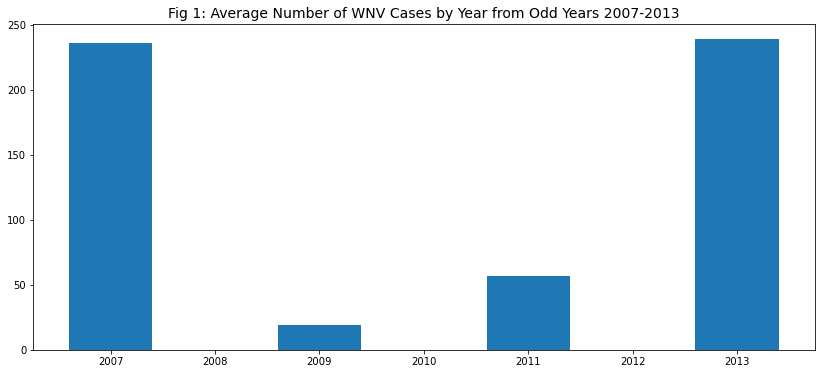

In [33]:
wnv_avg = train.groupby(['year'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(wnv_avg['year'], wnv_avg['wnv_present'])
plt.title('Fig 1: Average Number of WNV Cases by Year from Odd Years 2007-2013', fontsize=14)

Text(0.5, 1.0, 'Fig 2: Number of Records by Year from Odd Years 2007-2013')

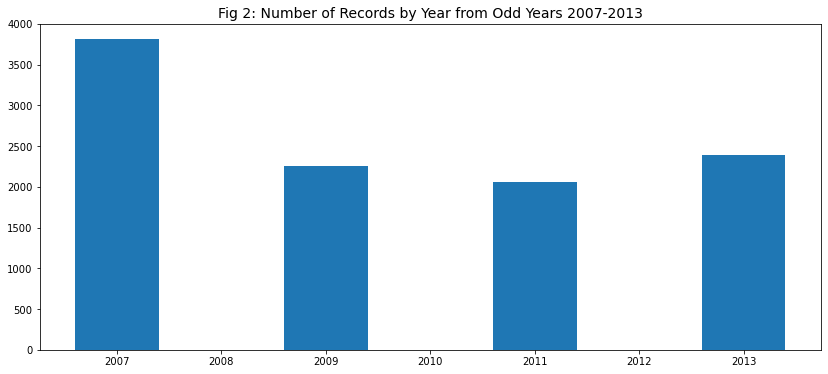

In [34]:
wnv_avg = train.groupby(['year'], as_index=False)['date'].count()
plt.figure(figsize=(14,6))
plt.bar(wnv_avg['year'], wnv_avg['date'])
plt.title('Fig 2: Number of Records by Year from Odd Years 2007-2013', fontsize=14)

### Weather Trends on WNV Cases

From **Figs 3-6** below, weather features were plotted against the number of WNV cases to examine if there are any patterns. Weather features which show certain patterns are ideal candidates to include into as part of the model features.

Text(0.5, 1.0, 'Fig 3: Temperature vs WNV Cases in Odd Years from 2007-2013')

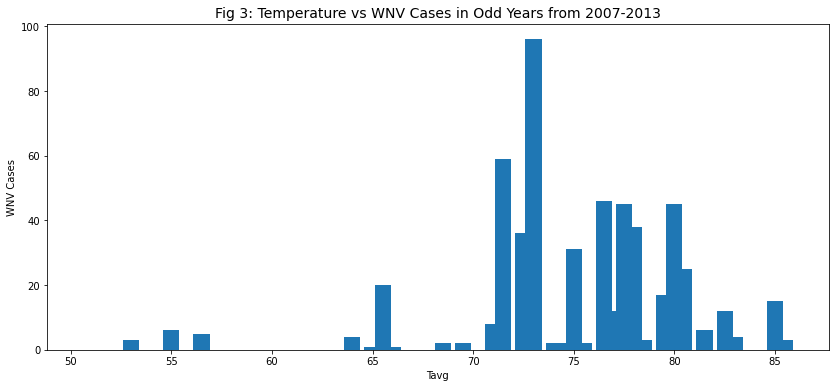

In [35]:
temp = train.groupby(['tavg'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(temp['tavg'], temp['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Tavg')
plt.title('Fig 3: Temperature vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

Higher Temperatures (>70 deg F) is associated with increases in WNV cases


Text(0.5, 1.0, 'Fig 4: Wind Speed (mi/h) vs WNV Cases in Odd Years from 2007-2013')

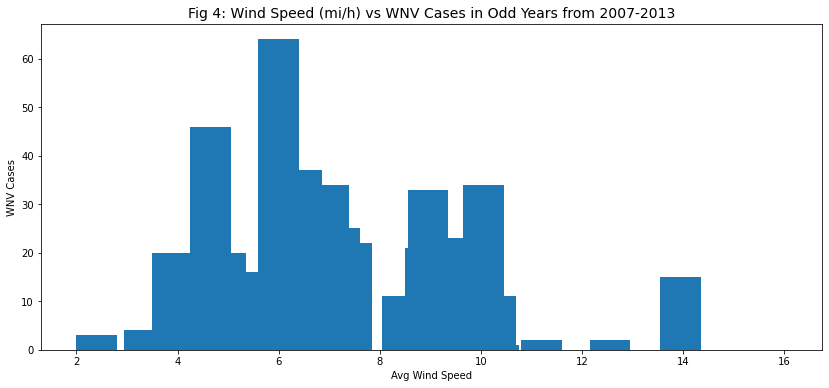

In [36]:
wind= train.groupby(['avg_speed'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(wind['avg_speed'], wind['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Avg Wind Speed')
plt.title('Fig 4: Wind Speed (mi/h) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

Lower Wind Speeds (<8 mi/hr) is associated with increases in WNV cases

Text(0.5, 1.0, 'Fig 5: Air Pressure (Hg) vs WNV Cases in Odd Years from 2007-2013')

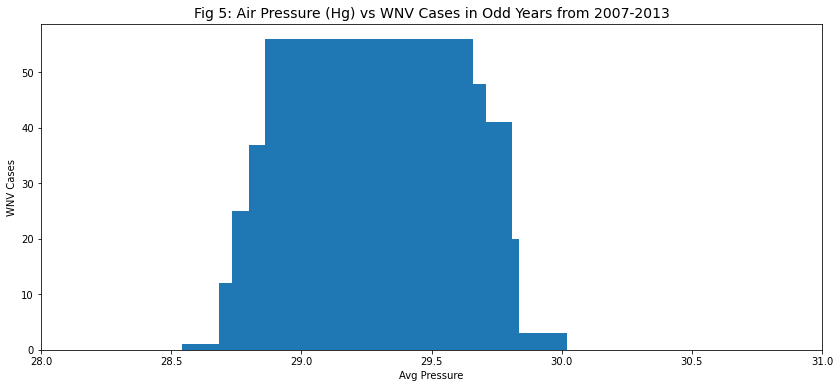

In [37]:
stn_pressure = train.groupby(['stn_pressure'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(stn_pressure['stn_pressure'], stn_pressure['wnv_present'])
plt.xlim((28,31))
plt.ylabel('WNV Cases')
plt.xlabel('Avg Pressure')
plt.title('Fig 5: Air Pressure (Hg) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

The majority of WNV cases were recorded when Air Pressure in between 28.6-29.8 Hg 

Text(0.5, 1.0, 'Fig 6: Daylight Hours (hrs) vs WNV Cases in Odd Years from 2007-2013')

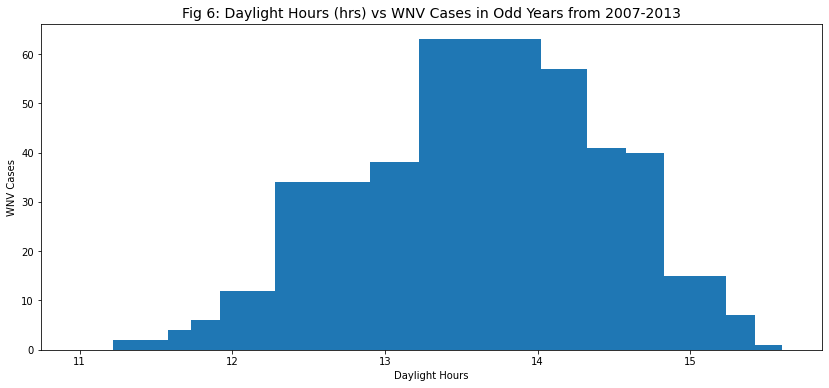

In [38]:
daylight = train.groupby(['daylight_hours'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(daylight['daylight_hours'], daylight['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Daylight Hours')
plt.title('Fig 6: Daylight Hours (hrs) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

The majority of WNV cases were recorded between 13.5-14.2 daylight hours


Text(0.5, 1.0, 'Fig 7: Relative Humidity (%) vs WNV Cases in Odd Years from 2007-2013')

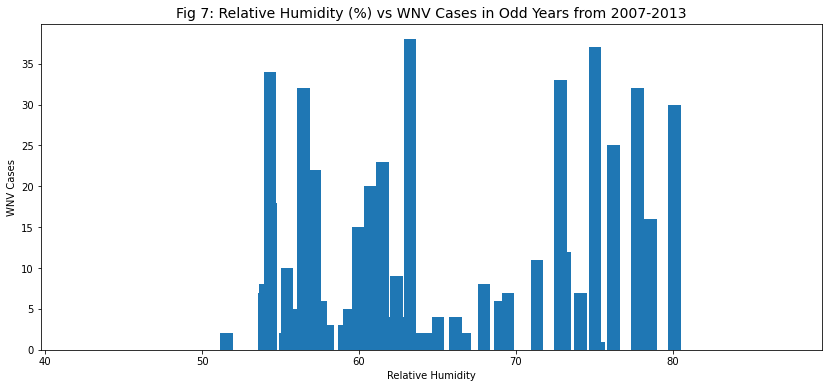

In [39]:
rh= train.groupby(['r_humidity'], as_index=False)['wnv_present'].sum()
plt.figure(figsize=(14,6))
plt.bar(rh['r_humidity'], rh['wnv_present'])
plt.ylabel('WNV Cases')
plt.xlabel('Relative Humidity')
plt.title('Fig 7: Relative Humidity (%) vs WNV Cases in Odd Years from 2007-2013', fontsize=14)

There were no WNV cases when RH was below 50

## Seasonal Trends

To see if there was any seasonal trend within a year for WNV cases, the mean cases per Year-Week was plotted from the train dataset in **Fig 8** (i.e. number of WNV cases recorded per Year-Week/number of records per Year-Week)

From **Fig 8**, it is observed that there is a gradual build-up and peaking of mean WNV cases in weeks 33-35, followed by a gradual tapering till Week 40. 

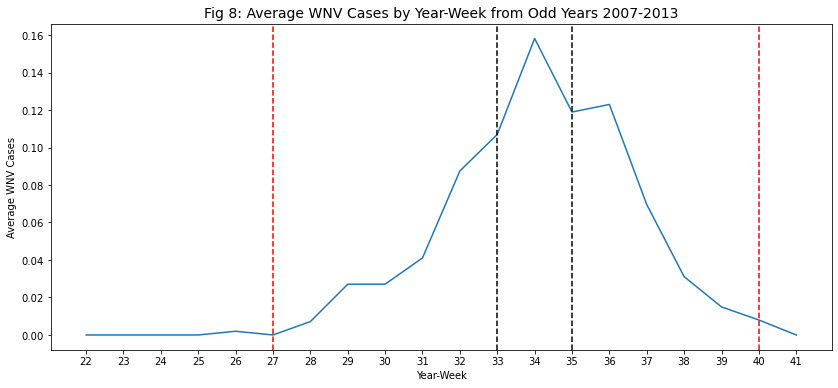

In [40]:
wnv_avg = train.groupby(['week_of_year'], as_index=False)['wnv_present'].mean()
plt.figure(figsize=(14,6))
plt.plot(wnv_avg['week_of_year'], wnv_avg['wnv_present'])
plt.xticks(range(22,42))
plt.ylabel('Average WNV Cases') 
plt.xlabel('Year-Week')
plt.title('Fig 8: Average WNV Cases by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black')

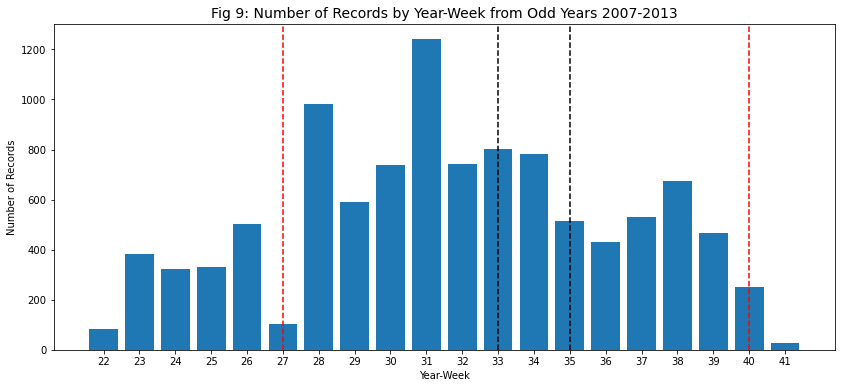

In [41]:
records = train.groupby(['week_of_year'], as_index=False)['date'].count()
plt.figure(figsize=(14,6))
plt.bar(records['week_of_year'], records['date'])
plt.xticks(range(22,42))
plt.ylabel('Number of Records')  
plt.xlabel('Year-Week')
plt.title('Fig 9: Number of Records by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black')

**Fig 8** shows that the increased number of cases was not due to simply an increase in records as the distribution of the records by Year-Week do not coincide with the build-up and tapering off pattern in weeks 27-40 in **Fig 7**. 

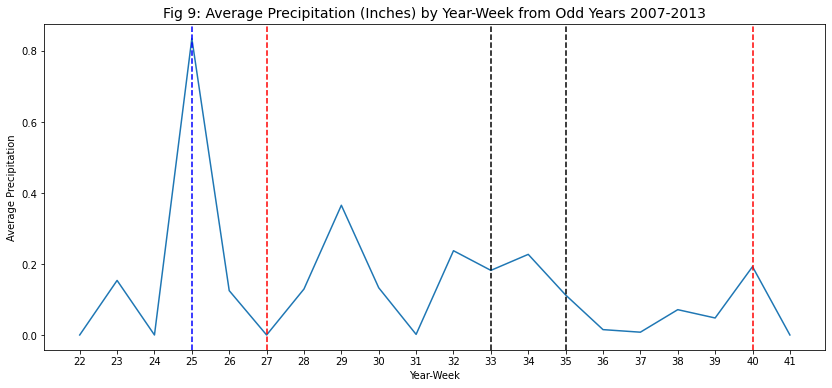

In [42]:
precip_avg = train.groupby(['week_of_year'], as_index=False)['precip_total'].mean()
plt.figure(figsize=(14,6))
plt.plot(precip_avg['week_of_year'], precip_avg['precip_total'])
plt.xticks(range(22,42))
plt.ylabel('Average Precipitation') 
plt.xlabel('Year-Week')
plt.title('Fig 9: Average Precipitation (Inches) by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(25, linestyle='--', color='b')
plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black')

High precipitation rates results in greater generation of water surfaces for mosquito breeding, increasing the overall mosquito population and increase the chances of the spead of WNV. However, excessive precipitation also has also been known to ['flush' away mosquito larvae and decrease their life expectancy](https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0006935). The typical time for mosquitos of the Culex species to reach adulthood is about [2-4 weeks](https://www.in.gov/health/erc/zoonotic-and-vectorborne-epidemiology-entomology/pests/culex-species-mosquitoes/), and life expectancy of the Culex species of mosquitos is about


From **Fig 9**, we observe that high precipitation traditionally occurs in Week 25, followed by a prolonged period of low precipitation especially in Weeks 27-40. It may be likely that the high rainfall from week 25 generated large amounts of surfaces for mosquito breeding, with the lower precipitation in the proceeding 2 weeks (Weeks 26-28) facilitating the growth of larvae into adult mosquitos and contributing to the build-up in cases from Week 27-35.

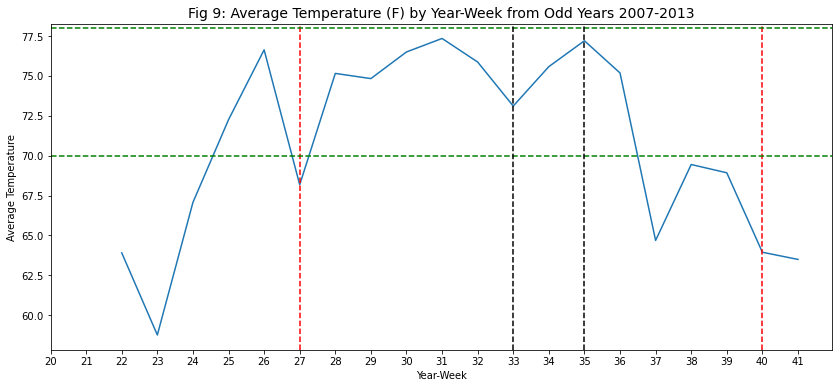

In [43]:
temp_avg = train.groupby(['week_of_year'], as_index=False)['tavg'].mean()
plt.figure(figsize=(14,6))
plt.plot(temp_avg['week_of_year'], temp_avg['tavg'])
plt.xticks(range(20,42))
plt.ylabel('Average Temperature') 
plt.xlabel('Year-Week')
plt.title('Fig 9: Average Temperature (F) by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axhline(70, linestyle='--', color='g')
plt.axhline(78, linestyle='--', color='g')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black')

Studies have shown that WNV cases generally occur when ambient temperature is between [70-79 degrees Fahrenheit](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7492091/), **Fig 9** seems to corroborate the studies as 
the temperature was within this band with during the peak of WNV cases (Weeks 33-35).

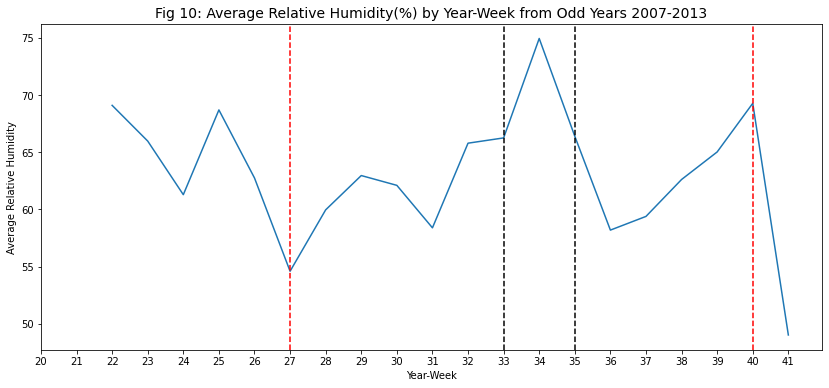

In [44]:
rh_avg = train.groupby(['week_of_year'], as_index=False)['r_humidity'].mean()
plt.figure(figsize=(14,6))
plt.plot(rh_avg['week_of_year'], rh_avg['r_humidity'])
plt.xticks(range(20,42))
plt.ylabel('Average Relative Humidity') 
plt.xlabel('Year-Week')
plt.title('Fig 10: Average Relative Humidity(%) by Year-Week from Odd Years 2007-2013', fontsize=14)
plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black')


The RH values shown in **Fig 10** follows the trend of WNV cases in **Fig 8**.

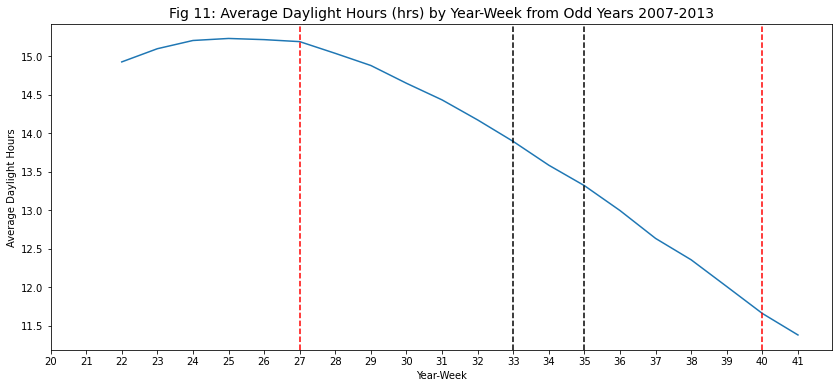

In [45]:
daylight_avg = train.groupby(['week_of_year'], as_index=False)['daylight_hours'].mean()
plt.figure(figsize=(14,6))
plt.plot(daylight_avg['week_of_year'], daylight_avg['daylight_hours'])
plt.xticks(range(20,42))
plt.ylabel('Average Daylight Hours') 
plt.xlabel('Year-Week')
plt.title('Fig 11: Average Daylight Hours (hrs) by Year-Week from Odd Years 2007-2013', fontsize=14)

plt.axvline(27, linestyle='--', color='r')
plt.axvline(40, linestyle='--', color='r')
plt.axvline(33, linestyle='--', color='black')
plt.axvline(35, linestyle='--', color='black')

The average daylight hours recorded decreases from Week 27 onwards as seen from **Fig 11**, which may indicate that the increase in night-time hours/decrease in day-time hours may exacerbate mosquito activity and lead to an increase in WNV cases

### WNV Cases by Mosquito Species

From **Fig 12** & **Fig 13**, it can be seen that the main species which are trapped and found to have the WNV are the CULEX RESTUANS, CULEX PIPIENS and CULEX PIPIENS/RESTUANS species of mosquitos. WNV was not found on the other four species of mosquitos despite records of trapping all 7 species.

As the num_mosquitos feature is not in test dataset, we would need to impute values to create that feature for the test dataset, this would likely create an additional layer of complexity which may not improve our model. As such, we will drop the num_mosquitos feature.

As the species feature is nominal, we will create dummy variables the other mosquitos under the 'OTHERS' category to reduce the number of unnecessary features for modelling later.

                  species  num_mosquitos
0         CULEX ERRATICUS              7
1           CULEX PIPIENS          44671
2  CULEX PIPIENS/RESTUANS          66268
3          CULEX RESTUANS          23431
4        CULEX SALINARIUS            145
5          CULEX TARSALIS              7
6         CULEX TERRITANS            510


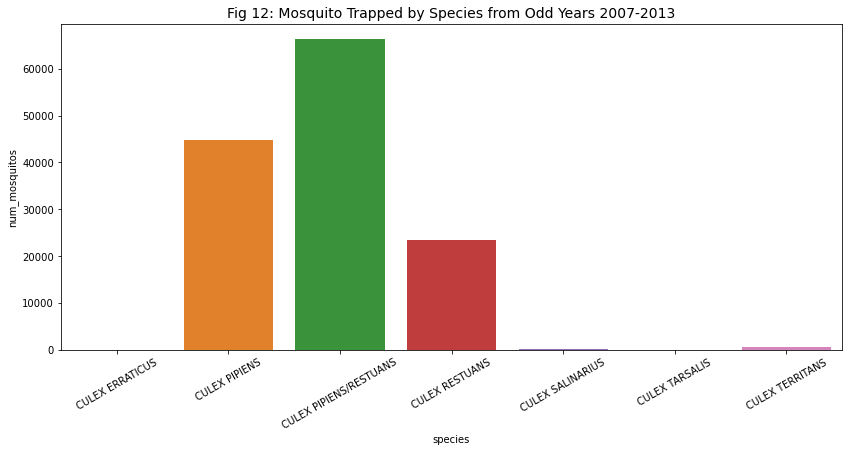

In [46]:
species_trapped = train.groupby(['species'], as_index=False)['num_mosquitos'].sum()
print(species_trapped)
plt.figure(figsize=(14,6))
sns.barplot(species_trapped['species'], species_trapped['num_mosquitos'])
plt.xticks(rotation=30)
plt.title('Fig 12: Mosquito Trapped by Species from Odd Years 2007-2013', fontsize=14)

# drop num_mosquitos from train
train.drop('num_mosquitos', axis=1, inplace=True)

                  species  wnv_present
0         CULEX ERRATICUS            0
1           CULEX PIPIENS          240
2  CULEX PIPIENS/RESTUANS          262
3          CULEX RESTUANS           49
4        CULEX SALINARIUS            0
5          CULEX TARSALIS            0
6         CULEX TERRITANS            0


Text(0.5, 1.0, 'Fig 13: WNV Cases by Mosquito Species from Odd Years 2007-2013')

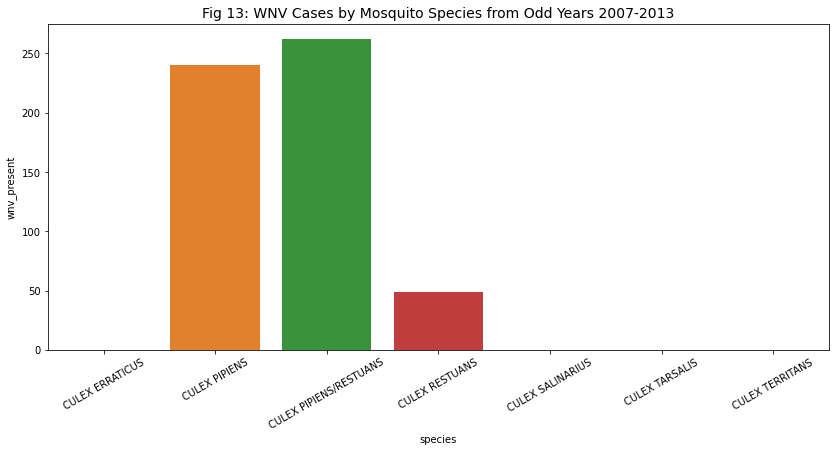

In [47]:
species_wnv = train.groupby(['species'], as_index=False)['wnv_present'].sum()
print(species_wnv)
plt.figure(figsize=(14,6))
sns.barplot(species_wnv['species'], species_wnv['wnv_present'])
plt.xticks(rotation=30)
plt.title('Fig 13: WNV Cases by Mosquito Species from Odd Years 2007-2013', fontsize=14)

In [48]:
minority_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
train['species'] = train['species'].apply(lambda x: 'OTHERS' if x not in minority_species else x)
heatmap_df = pd.get_dummies(train, columns=['species'], drop_first=True)

### Bivariate Analysis


All features do not show any strong correlation with the target variable ('wnv_present'). Some insights extracted from the correlation heatmap below:


* Strong negative correlation of daylight_hours with week_of_year and month. This relationship was earlier examined in **Fig 11**

There are strong correlations of certain features as well
* Moderate positive correlation of weather-related features (dew_point, precip_total, r_humidity)
* Strong positive correlation between month and week_of_year (expected because we can directly map week_of_year to a particular month)



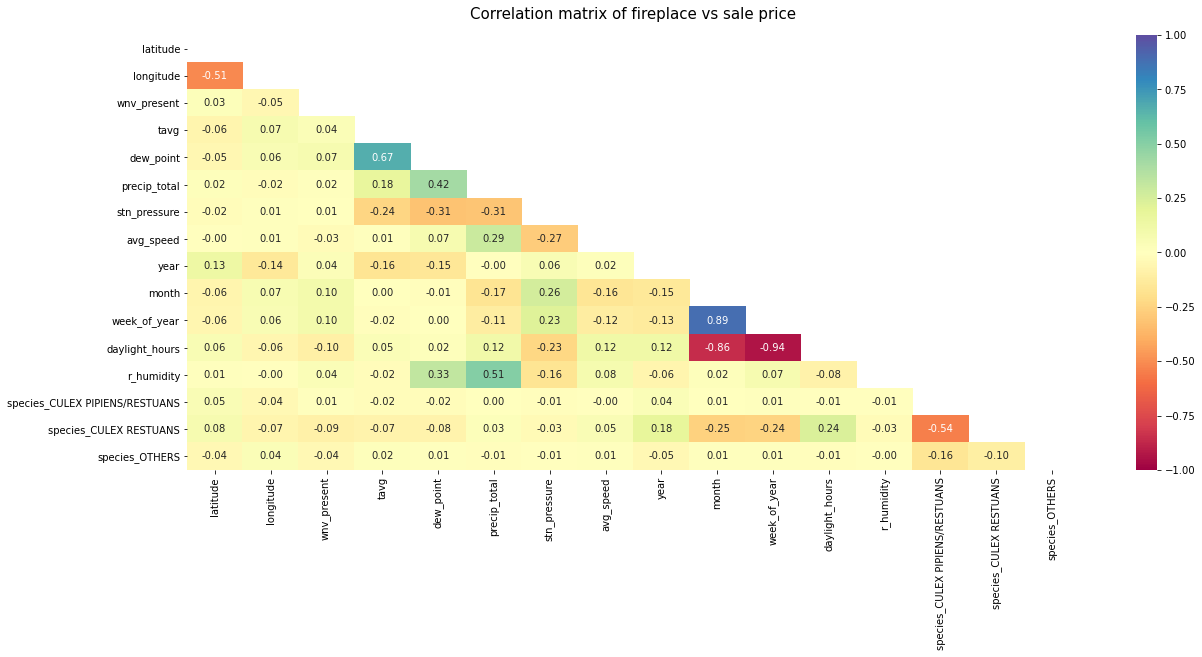

In [49]:
corr = heatmap_df.corr(method='kendall')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20, 8))
heatmap = sns.heatmap(
    corr, annot=True, fmt=".2f", mask=mask, cmap="Spectral", vmax=1, vmin=-1
)
heatmap.set_title(
    "Correlation matrix of fireplace vs sale price", fontdict={"fontsize": 15}, pad=16
);

# Modeling
***
The following models would be used:

|                |                  Models                 |
|:--------------:|:---------------------------------------:|
| Baseline Model |               BernoulliNB               |
|     Model 1    |            Logistic Regression          |
|     Model 2    |          Random Forest Classifier       |
|     Model 3    |        Gradient Boosting Classifier     |
|     Model 4    |              XGBoost Classifier         |

As we have an unbalanced classification problem, we will be using SMOTE to oversample the data to address the imbalance in the data through a pipeline and running the models afterwards. The choices of the models are a mix of tree based models and a linear model to see which model would perform the best.

## Model data preparation

### Get the X, y data

In [50]:
X = train.drop(['date', 'wnv_present'], axis = 1)
y = train['wnv_present']

In [51]:
print(X.shape)
print(y.shape)

(10506, 13)
(10506,)


In [52]:
y.value_counts(normalize = True)

0    0.947554
1    0.052446
Name: wnv_present, dtype: float64

### Train, test, split the data

In [53]:
X.columns

Index(['species', 'latitude', 'longitude', 'tavg', 'dew_point', 'precip_total',
       'stn_pressure', 'avg_speed', 'year', 'month', 'week_of_year',
       'daylight_hours', 'r_humidity'],
      dtype='object')

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [55]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7879, 13)
(2627, 13)
(7879,)
(2627,)


## Modeling Functions

In [56]:
# define the numerical columns

numerical_cols = ['latitude', 'longitude', 'tavg', 'dew_point', 'precip_total',\
                  'stn_pressure', 'avg_speed', 'daylight_hours', 'r_humidity', 'year',\
                  'month', 'week_of_year']
categorical_cols = ['species']

In [57]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown = "ignore")

# Bundle preprocessing for numerical and categorical data
transformer = ColumnTransformer(
    transformers = [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [58]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input column transformer and model
def run_model(X_train, X_test, y_train, y_test, mod, mod_params = {}, grid_search = False):
    
    # Initial dictionary to hold model results
    results = {}
  
    pipe = imblearnpipe([
        ('t', transformer),
        ('sampling', SMOTE(random_state = 42)),
        (mod, models[mod])
    ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid = mod_params, cv = 5, verbose = 1, scoring = 'roc_auc', n_jobs = -2)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    cm_df = pd.DataFrame(confusion_matrix(y_test, predictions), 
                            index=['Actual Negative', 'Actual Postive'], 
                            columns=['Predicted Negative', 'Predicted Postive'])
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = round(roc_auc_score(y_train, y_train_pred_prob),3)
    results['test_auc'] = round(roc_auc_score(y_test, y_test_pred_prob),3)
    results['precision'] = round(precision_score(y_test, predictions),3)
    results['specificity'] = round(tn / (tn + fp),3)
    results['recall'] = round(recall_score(y_test, predictions),3)
    results['f_score'] = round(f1_score(y_test, predictions),3)
    
    if grid_search:
        gs_list.append(results)
        print('---Best Parameters---')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('Model:', models[mod])
    print('---Model Metrics---')
    display(results)
    display(cm_df)
    print(f"True Negatives: {tn}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
        
    print()
    return pipe

In [59]:
def features_plot_lr(mod, title, X = X_train):
    """Function to plot feature importance from models"""
    col = mod.best_estimator_.steps[0][1].get_feature_names_out()
    impt = mod.best_estimator_.steps[2][1].coef_.ravel()

    temp_df = pd.DataFrame(index = col, data = impt, columns = ['features'])
    temp_df.sort_values(by = 'features').plot(kind = 'barh' , figsize = (16,9))
    plt.title(f'Feature Importance from {title}');

In [60]:
def features_plot(mod, title, X = X_train):
    """Function to plot feature importance from models"""
    col = mod.best_estimator_.steps[0][1].get_feature_names_out()
    impt = mod.best_estimator_.steps[2][1].feature_importances_

    temp_df = pd.DataFrame(index = col, data = impt, columns = ['features'])
    temp_df.sort_values(by = 'features').plot(kind = 'barh' , figsize = (16,9))
    plt.title(f'Feature Importance from {title}');

## Model Tuning


In [61]:
# Instantiate the models
models = {'nb': BernoulliNB(),
          'lr': LogisticRegression(),      
          'rf': RandomForestClassifier(random_state = 42),
          'gb': GradientBoostingClassifier(random_state = 42),
          'xgb': XGBClassifier(objective = 'binary:logistic', random_state = 42, use_label_encoder = False)
        }

### Baseline Model

We will be using Bernoulli Naive Bayer as our baseline model as we are working with a binary classification problem.

In [62]:
%%time
nb = run_model(X_train, X_test, y_train, y_test, 'nb')

Model: BernoulliNB()
---Model Metrics---


{'model': 'nb',
 'train_auc': 0.765,
 'test_auc': 0.74,
 'precision': 0.09,
 'specificity': 0.592,
 'recall': 0.725,
 'f_score': 0.159}

,Predicted Negative,Predicted Postive
Actual Negative,1473,1016
Actual Postive,38,100


True Negatives: 1473
False Negatives: 38
True Positives: 100
False Positives: 1016

Wall time: 83.8 ms


### Candidate Models Tuning

#### Logistic Regression

In [63]:
lr_params = {'sampling__sampling_strategy': ['auto'], # ['minority', 'auto']
             'sampling__k_neighbors': [7, 8, 9], # [4, 5, 6, 7, 8, 9]
             'lr__penalty' : ['l1'], #['l1', 'l2']
             'lr__max_iter' : [5000],
             'lr__solver' : ['saga'], # ['liblinear', 'saga']
             'lr__C' : [0.4, 0.6, 0.8], # [0.4, 0.6, 0.8, 1.0, 1.2]
             'lr__class_weight' : ['balanced'] # [None, 'balanced']
            }

In [64]:
%%time
lr = run_model(X_train, X_test, y_train, y_test, 'lr', lr_params, grid_search = True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
---Best Parameters---


{'lr__C': 0.4,
 'lr__class_weight': 'balanced',
 'lr__max_iter': 5000,
 'lr__penalty': 'l1',
 'lr__solver': 'saga',
 'sampling__k_neighbors': 7,
 'sampling__sampling_strategy': 'auto'}

Model: LogisticRegression()
---Model Metrics---


{'model': 'lr',
 'train_auc': 0.797,
 'test_auc': 0.79,
 'precision': 0.112,
 'specificity': 0.677,
 'recall': 0.732,
 'f_score': 0.194}

,Predicted Negative,Predicted Postive
Actual Negative,1685,804
Actual Postive,37,101


True Negatives: 1685
False Negatives: 37
True Positives: 101
False Positives: 804

Wall time: 6.06 s


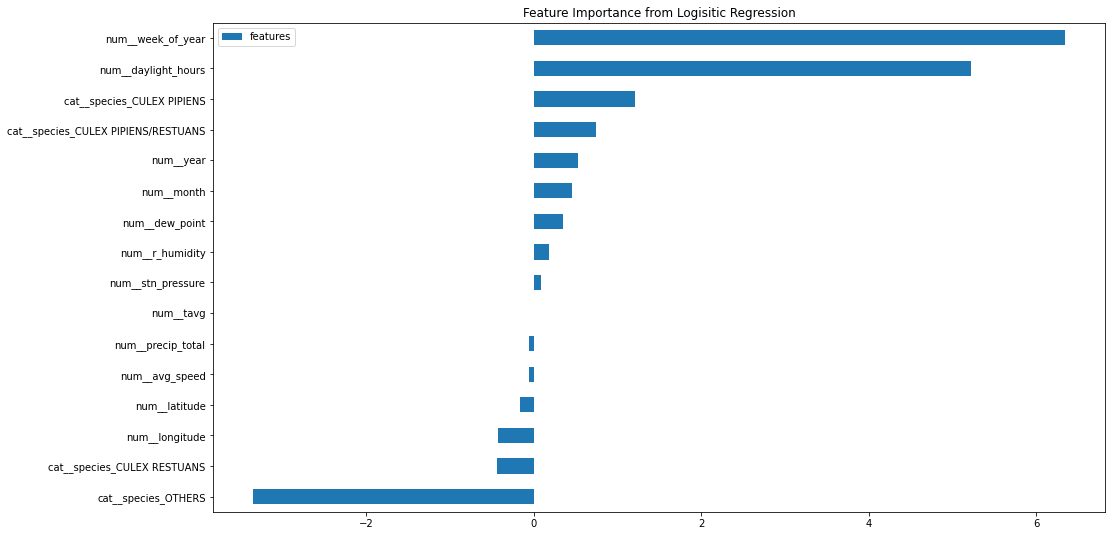

In [65]:
features_plot_lr(lr, 'Logisitic Regression')

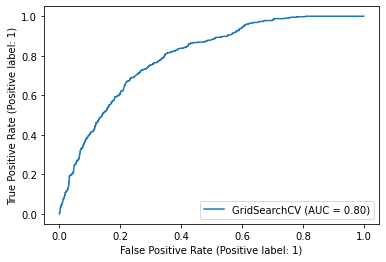

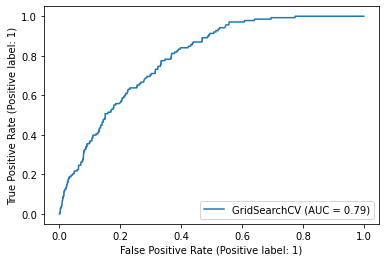

In [66]:
# plot the AUC ROC curve
plot_roc_curve(lr, X_train, y_train)
plot_roc_curve(lr, X_test, y_test);

#### Random Forest

In [67]:
rf_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
             'sampling__k_neighbors': [5],  # [4, 5, 6]
             'rf__n_estimators': [200], # [50, 100, 150, 200, 250, 300]
             'rf__min_samples_split' : [2], # [2, 4, 6, 8]
             'rf__max_depth': [9], # [5, 7, 9, 11, 13, 15]
             'rf__min_samples_leaf': [7], # [3, 5, 7, 8, 9]]
             'rf__class_weight' : ['balanced'] # ['balanced', 'balanced_subsample']
            }

In [68]:
%%time
rf = run_model(X_train, X_test, y_train, y_test, 'rf', rf_params, grid_search = True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'rf__class_weight': 'balanced',
 'rf__max_depth': 9,
 'rf__min_samples_leaf': 7,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 200,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority'}

Model: RandomForestClassifier(random_state=42)
---Model Metrics---


{'model': 'rf',
 'train_auc': 0.894,
 'test_auc': 0.823,
 'precision': 0.158,
 'specificity': 0.816,
 'recall': 0.623,
 'f_score': 0.252}

,Predicted Negative,Predicted Postive
Actual Negative,2030,459
Actual Postive,52,86


True Negatives: 2030
False Negatives: 52
True Positives: 86
False Positives: 459

Wall time: 3.78 s


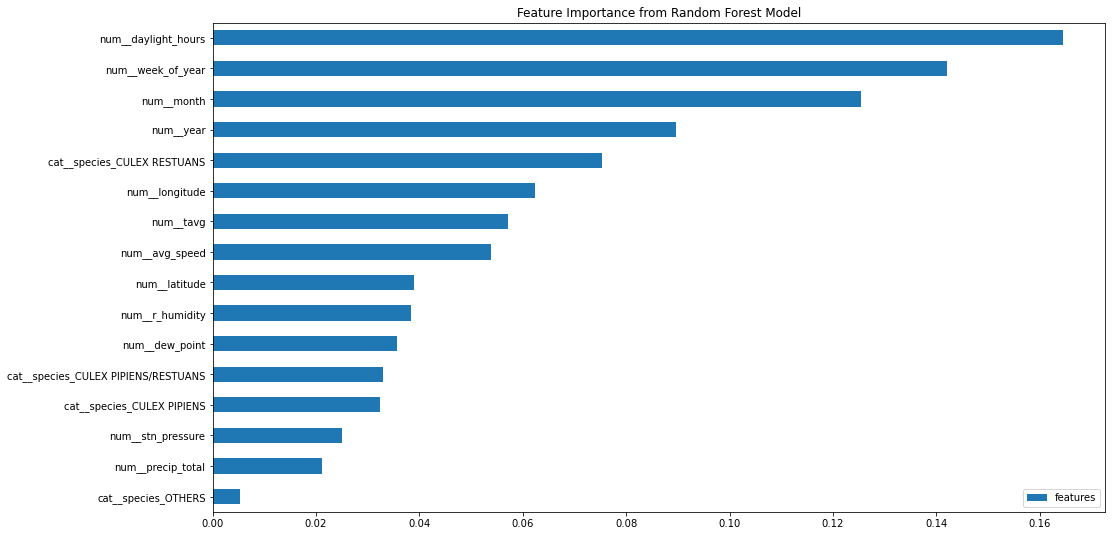

In [69]:
features_plot(rf, 'Random Forest Model')

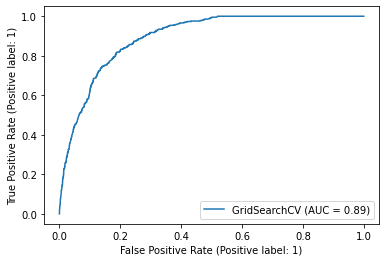

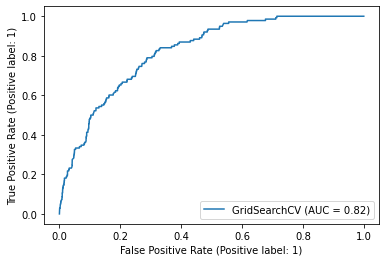

In [70]:
# plot the AUC ROC curve
plot_roc_curve(rf, X_train, y_train)
plot_roc_curve(rf, X_test, y_test);

#### Gradient Boosting Classifier

In [71]:
gb_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
             'sampling__k_neighbors': [5], # [4, 5, 6]
             'gb__max_depth': [4], # [2, 3, 4, 5]
             'gb__n_estimators': [100], # [50, 100, 150, 200]
             'gb__min_samples_leaf': [1], # [1, 3, 5]
             'gb__learning_rate': [.15] # [.08, .1, .13, .15, .17]
            }

In [72]:
%%time
gb = run_model(X_train, X_test, y_train, y_test, 'gb', gb_params, grid_search = True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---Best Parameters---


{'gb__learning_rate': 0.15,
 'gb__max_depth': 4,
 'gb__min_samples_leaf': 1,
 'gb__n_estimators': 100,
 'sampling__k_neighbors': 5,
 'sampling__sampling_strategy': 'minority'}

Model: GradientBoostingClassifier(random_state=42)
---Model Metrics---


{'model': 'gb',
 'train_auc': 0.901,
 'test_auc': 0.819,
 'precision': 0.19,
 'specificity': 0.883,
 'recall': 0.493,
 'f_score': 0.274}

,Predicted Negative,Predicted Postive
Actual Negative,2199,290
Actual Postive,70,68


True Negatives: 2199
False Negatives: 70
True Positives: 68
False Positives: 290

Wall time: 4.66 s


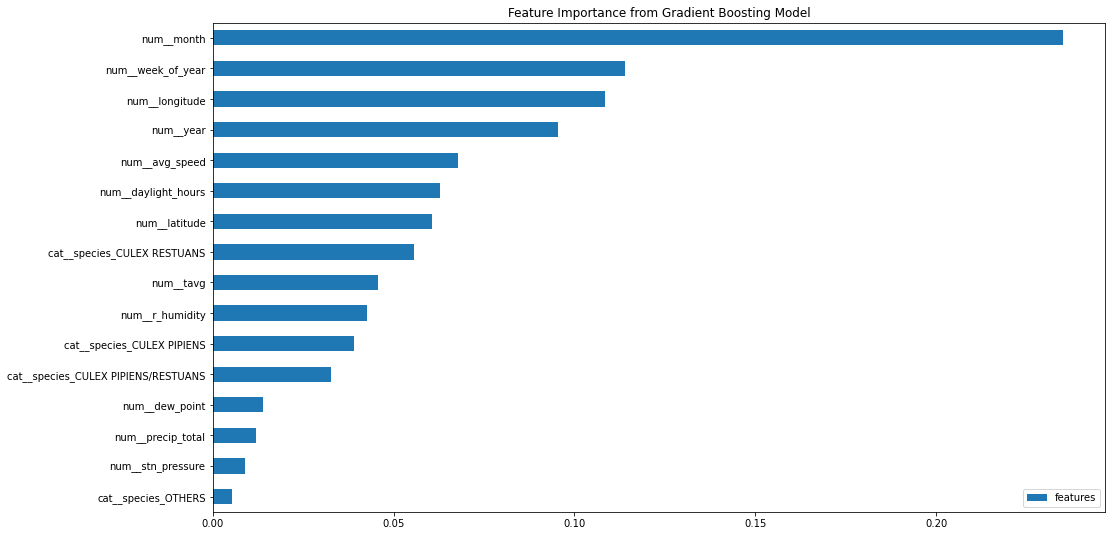

In [73]:
features_plot(gb, 'Gradient Boosting Model')

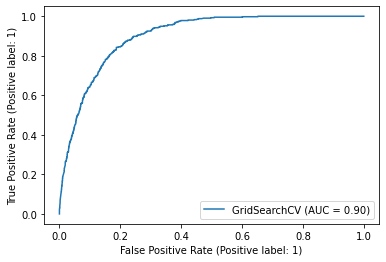

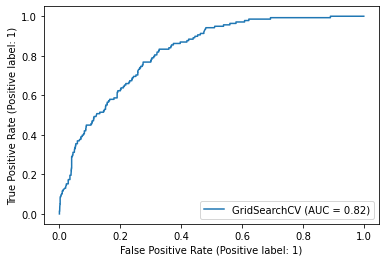

In [74]:
# plot the AUC ROC curve
plot_roc_curve(gb, X_train, y_train)
plot_roc_curve(gb, X_test, y_test);

#### XGBoost Classifier

In [75]:
xgb_params = {'sampling__sampling_strategy': ['minority'], # ['minority', 'auto']
              'sampling__k_neighbors': [4], #[2, 3, 4, 5, 6]
              'xgb__max_depth' : [4], # [2, 3, 4, 6, 8]
              'xgb__gamma' : [0], # [0 , 0.01 , 0.05]
              'xgb__learning_rate' : [0.1], # [.05, 0.1, 0.2, 0.3, 0.4]
              'xgb__n_estimators' : [40], # [20, 40, 60, 80, 100]
              'xgb__subsample' : [0.5], # [0.3, 0.5, 1]
              'xgb__colsample_bytree' : [1], # [0.5, 1]
              'xgb__lambda' : [0.5], # [0.1, 0.3, 0.5, 1, 5]
              'xgb__alpha' : [0.5] # [0, 0.5, 1]
             }

In [76]:
%%time
xgb = run_model(X_train, X_test, y_train, y_test, 'xgb', xgb_params, grid_search = True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[23:50:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
---Best Parameters---


{'sampling__k_neighbors': 4,
 'sampling__sampling_strategy': 'minority',
 'xgb__alpha': 0.5,
 'xgb__colsample_bytree': 1,
 'xgb__gamma': 0,
 'xgb__lambda': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 4,
 'xgb__n_estimators': 40,
 'xgb__subsample': 0.5}

Model: XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
---Model Metrics---


{'model': 'xgb',
 'train_auc': 0.874,
 'test_auc': 0.831,
 'precision': 0.157,
 'specificity': 0.789,
 'recall': 0.71,
 'f_score': 0.258}

,Predicted Negative,Predicted Postive
Actual Negative,1964,525
Actual Postive,40,98


True Negatives: 1964
False Negatives: 40
True Positives: 98
False Positives: 525

Wall time: 1.45 s


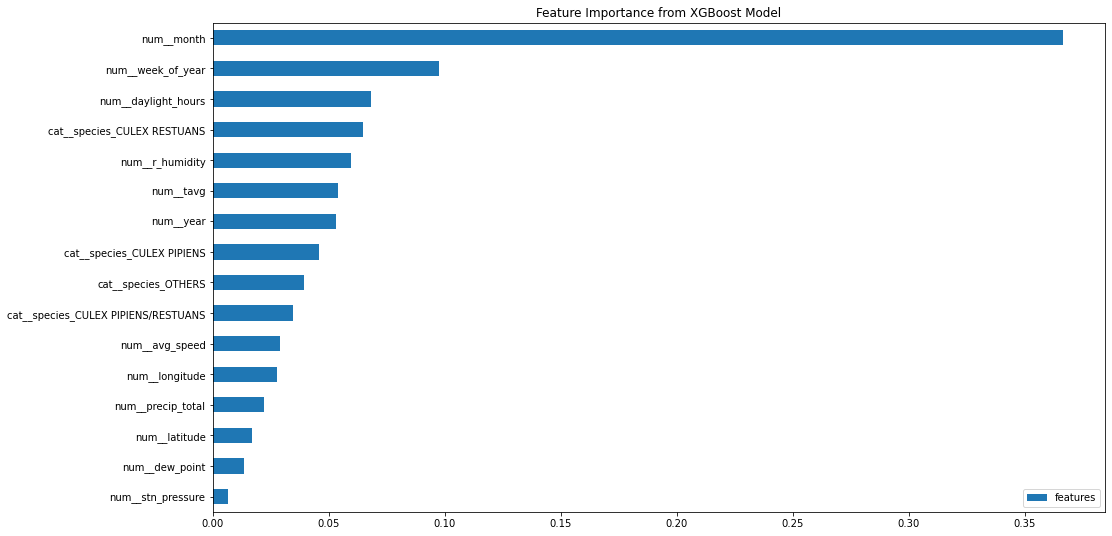

In [77]:
features_plot(xgb, 'XGBoost Model')

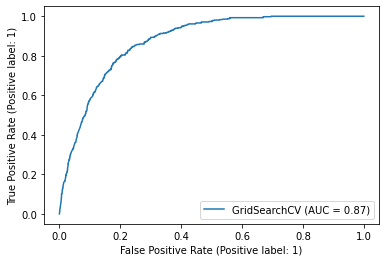

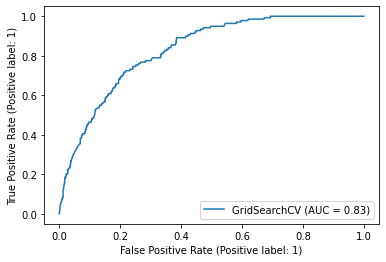

In [78]:
# plot the AUC ROC curve
plot_roc_curve(xgb, X_train, y_train)
plot_roc_curve(xgb, X_test, y_test);

### Plotting the ROC AUC Curves

In [90]:
def plot_roc_curves(model_dict, plot_top=False):
    """Function to plot all the ROC AUC curves of the models"""
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curves Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=12)

In [80]:
# define a dictionary of the models for use in the function
test_models = {lr : 'Logistic Regression',
               rf : 'Random Forest Classifier',
               gb : 'Gradient Boosting Classifier',
               xgb : 'XGB Classifier'
              }

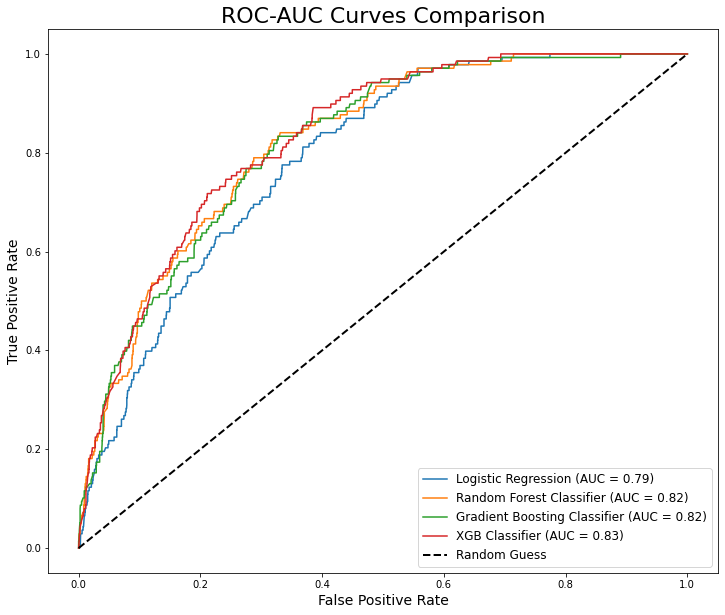

In [91]:
# plot the ROC-AUC curves of all the models
plot_roc_curves(test_models)

As seen from the ROC AUC curve, the logisitic regression model performed the worst out of all the models and the other three tree based models have roughly the same AUC score of 0.82 to 0.83. 

# Model Evaluation


**Summary of Results**

|                |            Models            | Train AUC | Test AUC | F-score |
|:--------------:|:----------------------------:|:---------:|:--------:|:-------:|
| Baseline Model |          BernoulliNB         |   0.765   |   0.740  |  0.159  |
|     Model 1    |      Logistic Regression     |   0.797   |   0.790  |  0.194  |
|     Model 2    |   Random Forest Classifier   |   0.894   |   0.823  |  0.252  |
|     Model 3    | Gradient Boosting Classifier |   0.901   |   0.819  |  0.274  |
|     Model 4    |      XGBoost Classifier      |   0.874   |   0.813  |  0.258  |

The best model from our testing is the Gradient Boosting Classifer model which achieve the highest F-score where it is a measure of a test's accuracy and it is the harmonic mean of the precision and recall. This could be because of the advantages of the Gradient Boosting Classifier model in which it is able to naturally handle of mixed data types, good predictive power and robustness to outliers. However, the hyperparameters are hard to tune and we can still observe overfitting for the model of our choice from the Train and Test AUC scores in the table above. This could be rectify in the future improvements. 

In [82]:
# Result list of baseline model
init_list

[{'model': 'nb',
  'train_auc': 0.765,
  'test_auc': 0.74,
  'precision': 0.09,
  'specificity': 0.592,
  'recall': 0.725,
  'f_score': 0.159}]

In [83]:
# Result list of the candidate models
gs_list

[{'model': 'lr',
  'train_auc': 0.797,
  'test_auc': 0.79,
  'precision': 0.112,
  'specificity': 0.677,
  'recall': 0.732,
  'f_score': 0.194},
 {'model': 'rf',
  'train_auc': 0.894,
  'test_auc': 0.823,
  'precision': 0.158,
  'specificity': 0.816,
  'recall': 0.623,
  'f_score': 0.252},
 {'model': 'gb',
  'train_auc': 0.901,
  'test_auc': 0.819,
  'precision': 0.19,
  'specificity': 0.883,
  'recall': 0.493,
  'f_score': 0.274},
 {'model': 'xgb',
  'train_auc': 0.874,
  'test_auc': 0.831,
  'precision': 0.157,
  'specificity': 0.789,
  'recall': 0.71,
  'f_score': 0.258}]

# Kaggle Submission

### Pre process the test data 

In [84]:
# drop date column
test.drop(columns = ['date'], inplace = True)

# change species column
minority_species = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']
test['species'] = test['species'].apply(lambda x: 'OTHERS' if x not in minority_species else x)

### Creating the dataframe for Kaggle submission

In [85]:
kaggle_pred = xgb.predict(test)
kaggle_pred

array([0, 0, 0, ..., 0, 0, 0])

In [86]:
# Reimport test dataset for ID Column
kaggle_df = pd.read_csv('data/test.csv')
kaggle_df = kaggle_df[['Id']]
kaggle_df['WnvPresent'] = kaggle_pred

In [87]:
kaggle_df.to_csv('data/kaggle_df.csv', index = False)

### Kaggle Results

For our best model of the Gradient Boosting Classifier, a public Kaggle score of 0.679 and a private Kaggle score of 0.666  was obtained.

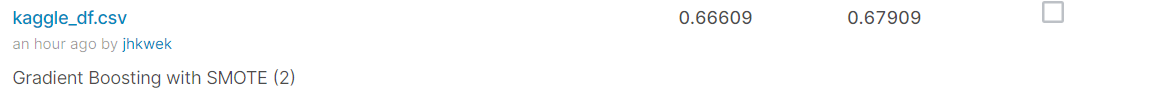

# Cost-Benefit Analysis

# Conclusion

### Limitation and Future Improvements

### Recommendations